# Contextual analysis

### Download libraries

In [ ]:
!pip install gensim
!pip install pyLDAvis
!pip install numpy

### Functions to upload, load and save files and models

In [1]:
import os

def get_file(name, upload=True):
  return os.path.exists(name)

def get_path(filename, folder='data'):
    return os.path.join('../{}/'.format(folder), filename)

def save_model(model, name):
  directory = '{}/{}/'.format('../data/models', name)
  if not os.path.exists(directory):
    os.makedirs(directory)
  model.save(os.path.join(directory, name))

def load_model(name, upload=True):
  directory = '{}/{}/'.format('../data/models', name)
  lda = models.LdaModel.load(os.path.join(directory, name))
  return lda

### Functions to upload, load and save files and models (run only if you use Google Colaboratory)

In [ ]:
import os
import shutil
import zipfile
from google.colab import files
from gensim import corpora, models, similarities

def get_file(name, upload=True):
  if not os.path.exists(name) and upload:
    uploaded = files.upload()
    data = list(uploaded.values())[0]
    with open(name, 'wb') as f:
      f.write(data)
  return os.path.exists(name)

def get_path(filename):
    return filename

def save_model(model, name):
  directory = '{}/{}/'.format('models', name)
  archive = '{}.zip'.format(name)
  if not os.path.exists(directory):
    os.makedirs(directory)
  model.save(os.path.join(directory, name))
  shutil.make_archive(name, 'zip', directory)
  print(archive)
  files.download(archive)

def load_model(name, upload=True):
  archive = '{}.zip'.format(name)
  if get_file(archive, upload) == False:
    return None
  zip_ref = zipfile.ZipFile(archive, 'r')
  zip_ref.extractall('.')
  zip_ref.close()
  lda = models.LdaModel.load(name)
  return lda

### Load tweets from json file

In [2]:
import json

file = get_path("tweets.json")

get_file(file)

raw_data = json.load(open(file))
data = json.loads(raw_data)

In [3]:
tweets = []
companies = []
id = 0
for company in data:
    name, nb_tw, _, _, _, _, _, tweet_list = company
    start = len(tweets)
    tweets += tweet_list
    companies.append((name, (start, len(tweets)), nb_tw, id))
    id += 1

### Generate a dictionary and a corpus of tweets (bag of words: (index, frequency))

In [4]:
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in tweets]
corpus[:2]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]

### Generate or load the lda (Latent Dirichlet allocation)

In [5]:
NB_TOPICS = 10
lda_filename = 'lda_model_{}'.format(NB_TOPICS)
lda = load_model(lda_filename)
if lda == None:
  lda = models.LdaModel(corpus, id2word=dictionary, num_topics=NB_TOPICS) # initialize an LSI transformation
  save_model(lda, lda_filename)
corpus_lda = lda[corpus] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

### Expore topics generated by lda and see the more frequents words

In [6]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print (u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print (u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [7]:
 explore_topic(2)

term                 frequency

vmware               0.065
vmworld              0.063
cloud                0.021
2017                 0.013
foundation           0.011
workspace            0.009
partners             0.009
news                 0.008
partnership          0.008
hybridcloud          0.008
public               0.008
nsx                  0.007
micro                0.007
learn                0.006
integration          0.006
new                  0.006
solutions            0.006
via                  0.006
converged            0.006
benefits             0.006
top                  0.006
private              0.006
data                 0.005
named                0.005
sddc                 0.005


### Graphical representation of topics

In [47]:
import pyLDAvis
import pyLDAvis.gensim

LDAvis_prepared = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(LDAvis_prepared)

/Users/couver_v/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


### Generate a proper np array (companies, topics) from the lda array

In [8]:
import numpy as np

def lda_to_np(lda):
  array = np.zeros((len(lda), NB_TOPICS))
  for i, topics in enumerate(lda):
    k = 0
    for j in range(NB_TOPICS):
      if k < len(topics) and topics[k][0] == j:
        array[i][j] = topics[k][1]
        k += 1
  return array

npy_filename = get_path('lda_np_{}.npy'.format(NB_TOPICS))
if get_file(npy_filename):
  lda_np = np.load(npy_filename)
else:
  lda_np = lda_to_np(corpus_lda)
  np.save(npy_filename, lda_np)

### Generate an array to represente the % of activation of a topic for each company (companies, activation of topic)

In [9]:
def get_company_id(nb):
  for i, company in enumerate(companies):
    if company[1][1] > nb:
      return i

In [10]:
companies_topics = np.zeros((len(companies), NB_TOPICS))
threshold = 0.05

for i, tweet in enumerate(lda_np):
  for j, topic in enumerate(tweet):
    if topic > threshold:
      companies_topics[get_company_id(i)][j] += 1

activations_topics = [[companies_topics[i][j] / companies[i][2] * 100 for j in range(len(companies_topics[i]))] for i in range(len(companies_topics))]


### Array of the mean activation of a topic for each company (companies, mean activation of topic)

In [11]:
def mean_topics(lda_np, companies):
  topics_by_company = []
  for company in companies:
    tweets = np.array(lda_np[company[1][0]:company[1][1]])
    company_topics = np.mean(tweets, 0)
    topics_by_company.append(company_topics)
  return np.array(topics_by_company)

companies_topics = mean_topics(lda_np, companies)

/Users/couver_v/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/couver_v/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


### Delete companies with NaN values or without non-zero value

In [12]:
def clear_companies(companies_topics, companies):
  clear_labels = []
  clear_topics = []
  for company, topics in zip(companies, companies_topics):
    if (not np.any(np.isnan(topics))) and np.any(topics):
      clear_labels.append(company[0])
      clear_topics.append(topics)
  return clear_labels, np.array(clear_topics)

clear_labels, clear_topics = clear_companies(companies_topics, companies)
_, clear_activations_topics = clear_companies(activations_topics, companies)

### "Normalize" topics

In [13]:
normalized_topics = [(topics - np.mean(topics)) / np.std(topics) for topics in clear_topics]
normalized_topics = np.array(normalized_topics)

normalized_activations_topics = [(topics - np.mean(topics)) / np.std(topics) for topics in clear_activations_topics]
normalized_activations_topics = np.array(normalized_activations_topics)

### Graphical representation of companies by topics on two dimensions (10 to 2 dimensions with t-SNE technique)

#### t-SNE mean

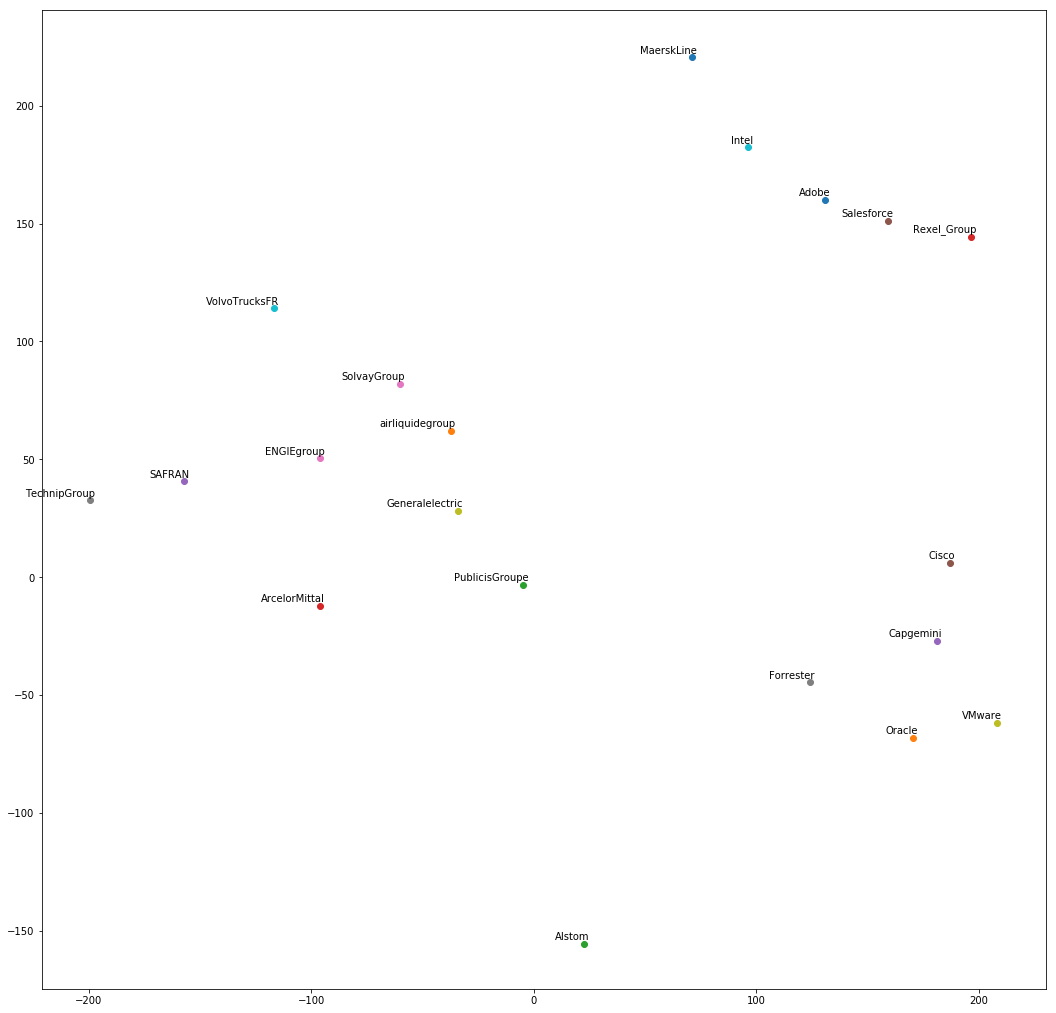

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename):
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  plt.savefig(get_path(filename, 'results'))
  plt.show()

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=500, method='exact')
low_dim_embs = tsne.fit_transform(clear_topics)
labels = companies
plot_with_labels(low_dim_embs, clear_labels, 'tsne_mean.png')


#### t-SNE normalized mean

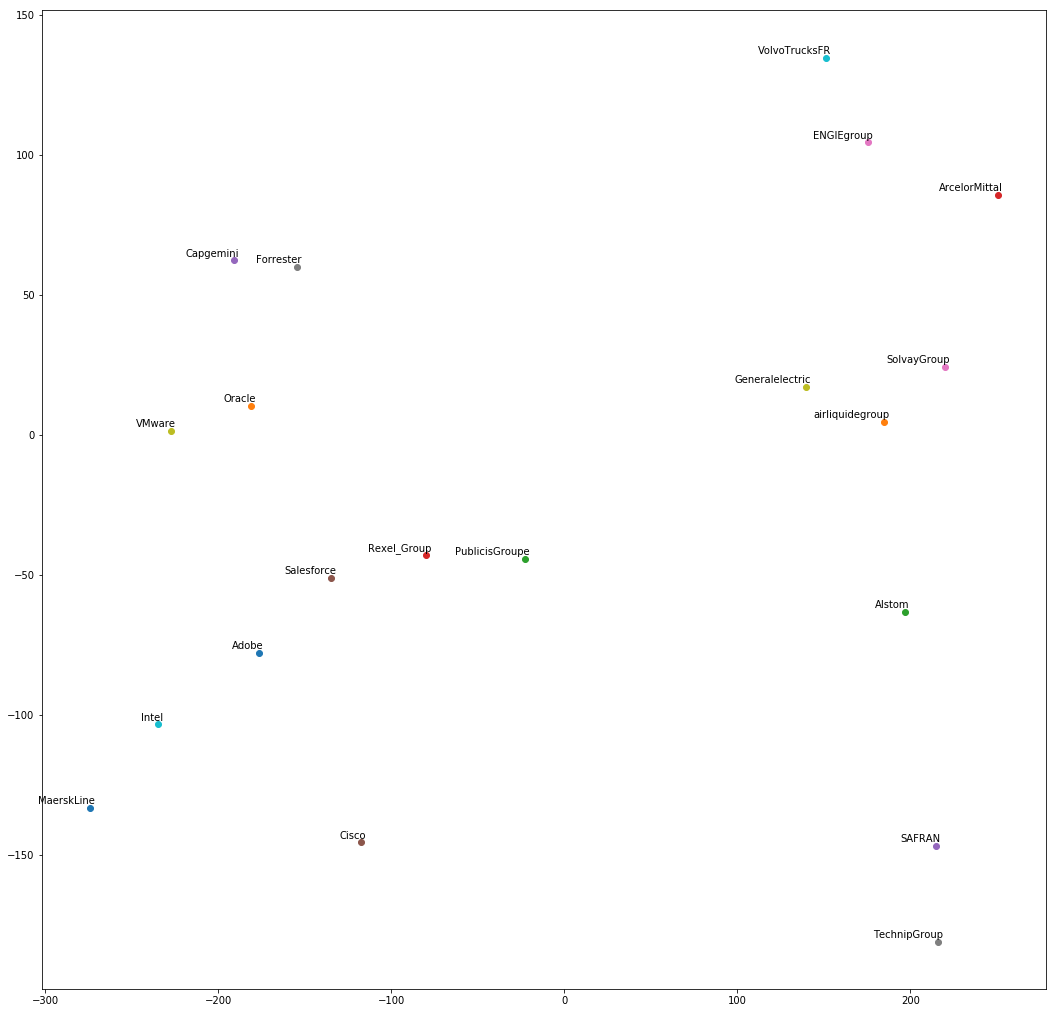

In [15]:
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=500, method='exact')
low_dim_embs = tsne.fit_transform(normalized_topics)
labels = companies
plot_with_labels(low_dim_embs, clear_labels, 'tsne_normalized_mean.png')

#### t-SNE activation

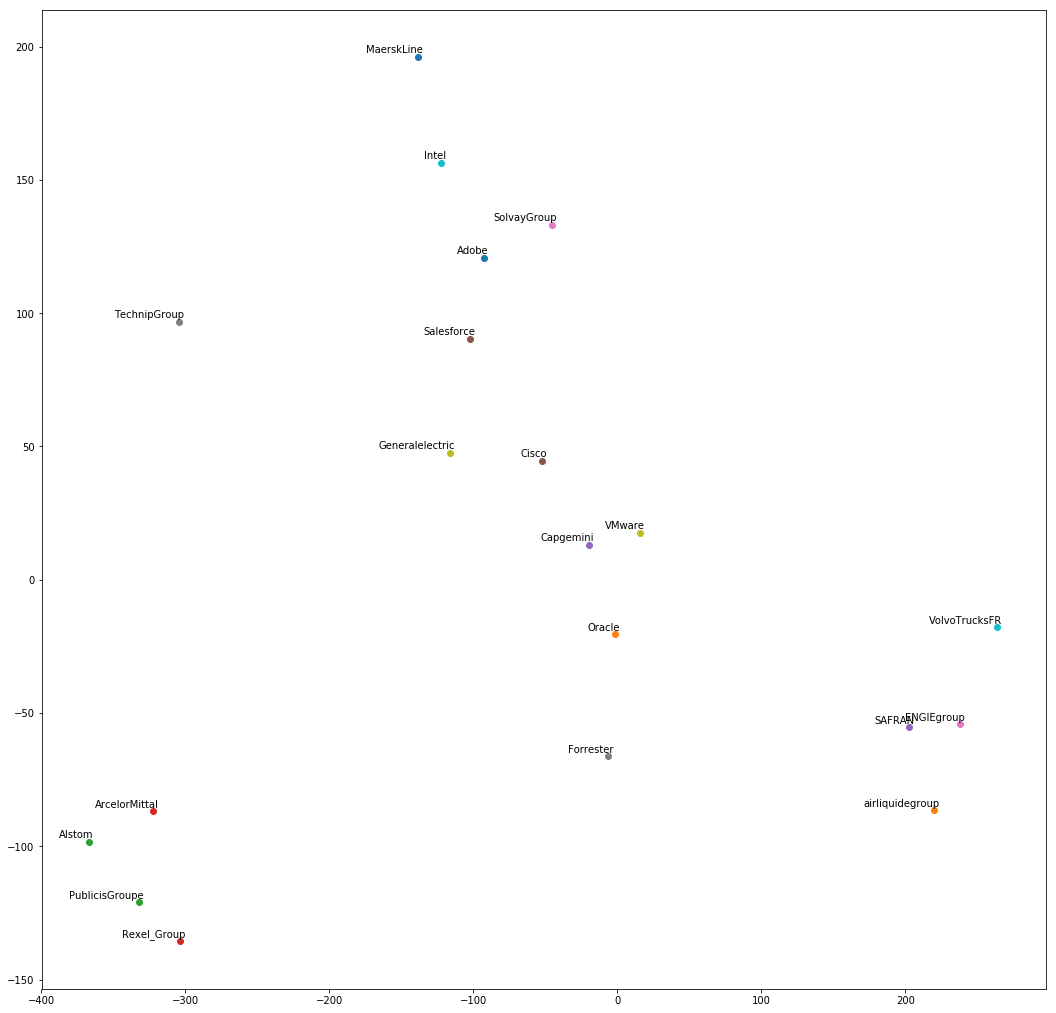

In [16]:
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=500, method='exact')
low_dim_embs = tsne.fit_transform(clear_activations_topics)
labels = companies
plot_with_labels(low_dim_embs, clear_labels, 'tsne_activation.png')

#### t-SNE normalized activation

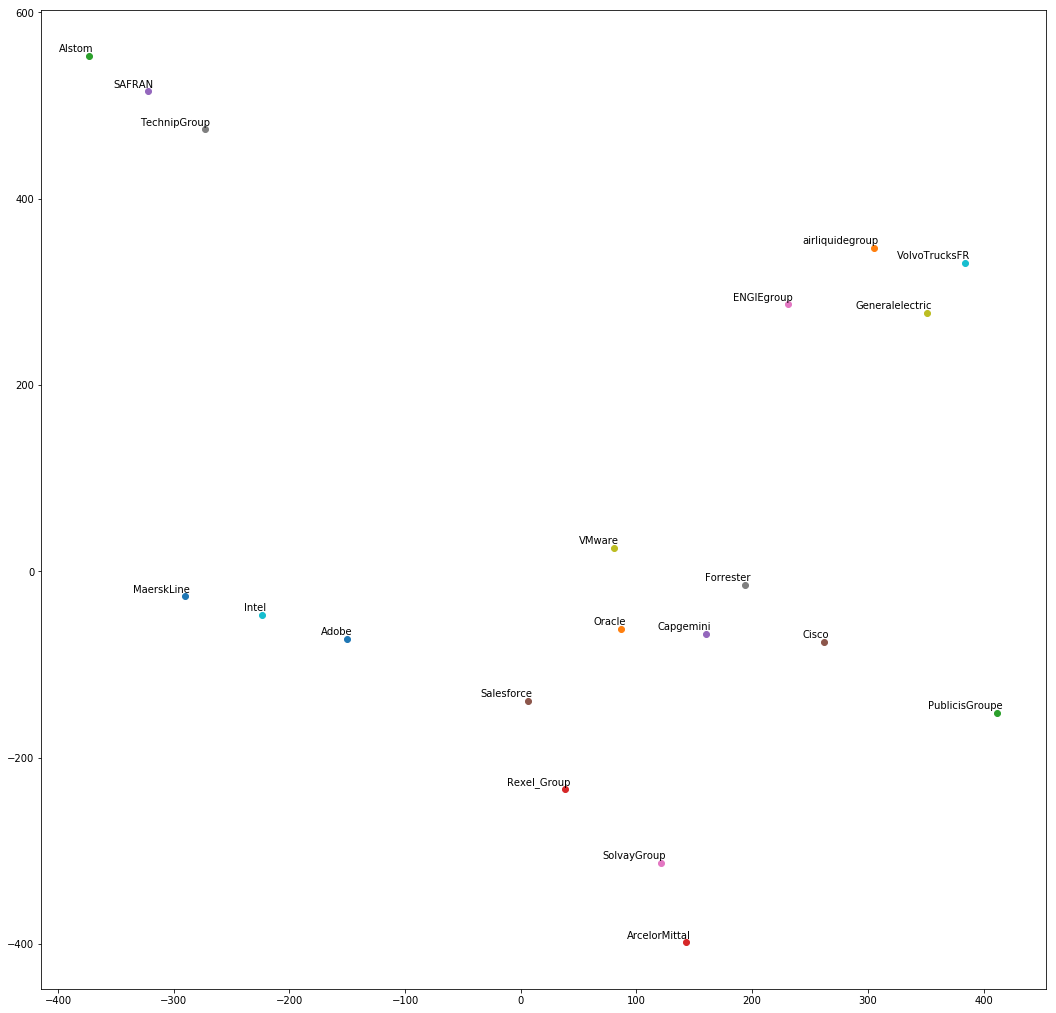

In [17]:
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=500, method='exact')
low_dim_embs = tsne.fit_transform(normalized_activations_topics)
labels = companies
plot_with_labels(low_dim_embs, clear_labels, 'tsne_normalized_activation.png')

### Graphical representation of companies by topics on two dimensions (only firsts two topics)

#### firsts topics mean

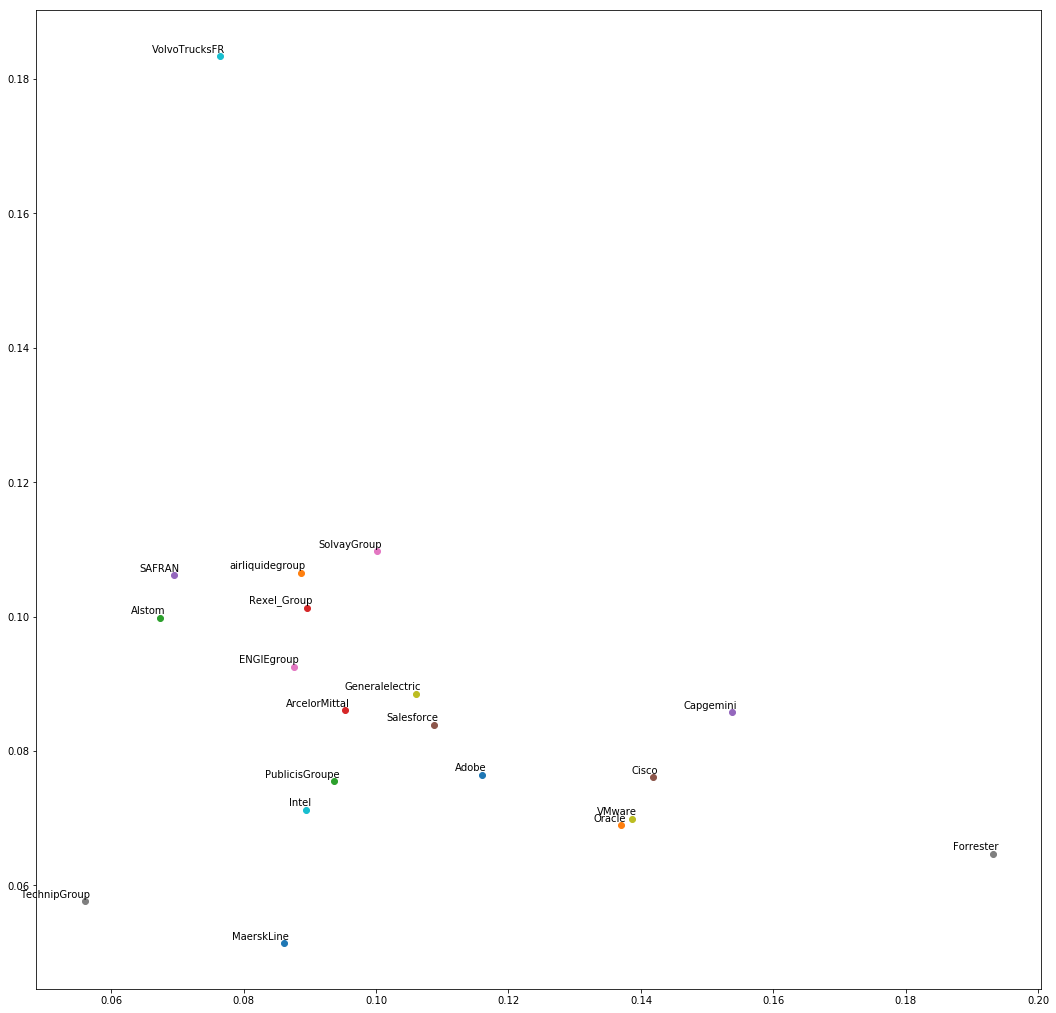

In [18]:
plot_with_labels(clear_topics[:, :2], clear_labels, 'firsts_topics_mean.png')

#### firsts topics normalized mean

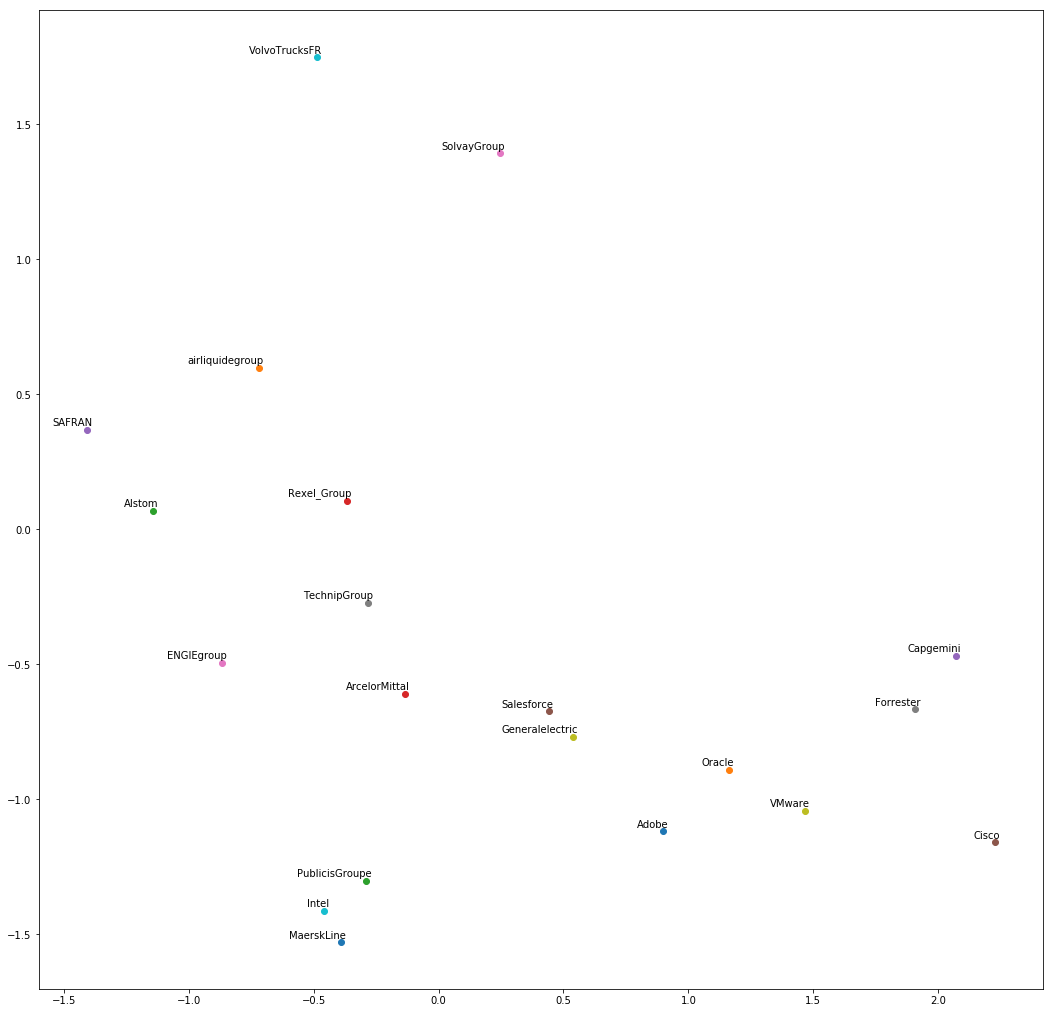

In [19]:
plot_with_labels(normalized_topics[:, :2], clear_labels, 'firsts_topics_normalized_mean.png')

#### firsts topics activation

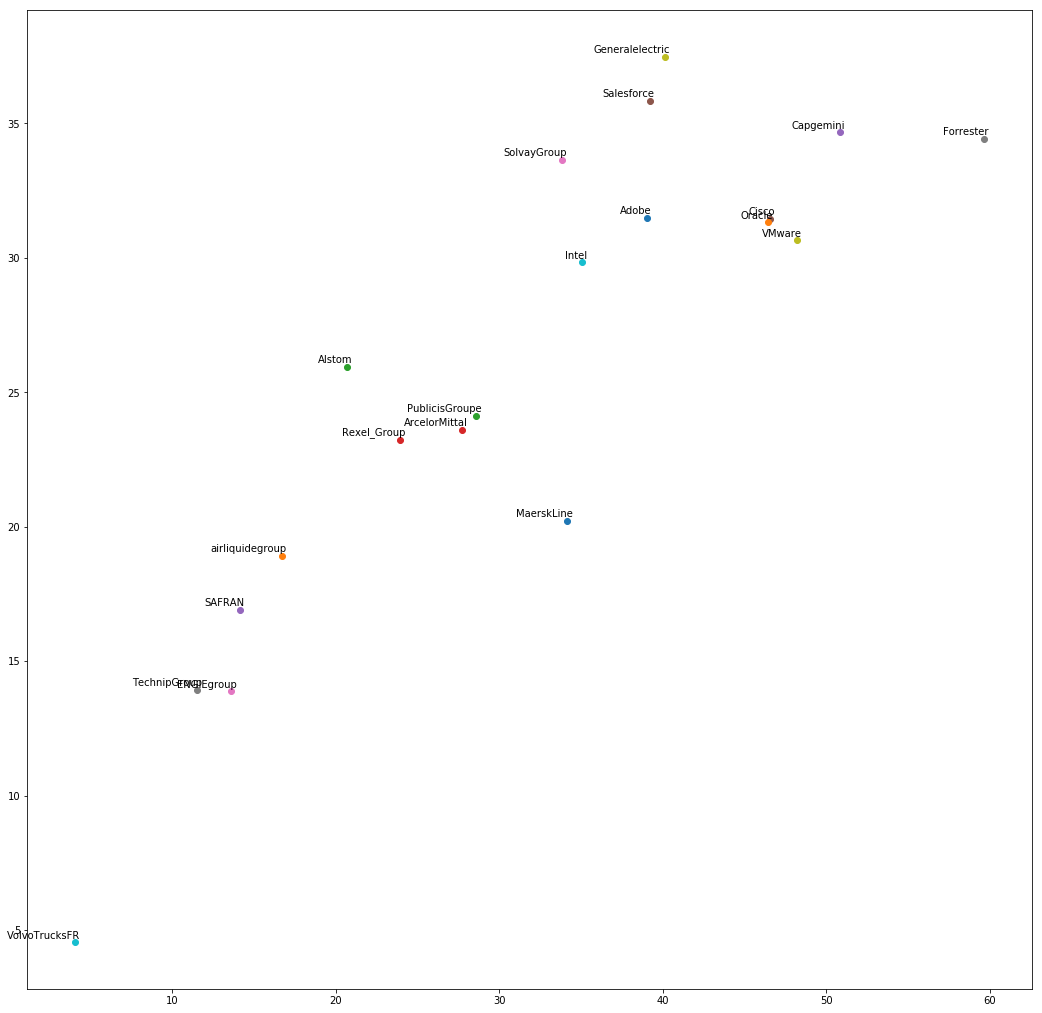

In [20]:
plot_with_labels(clear_activations_topics[:, :2], clear_labels, 'firsts_topics_activation.png')

#### firsts topics normalized activation

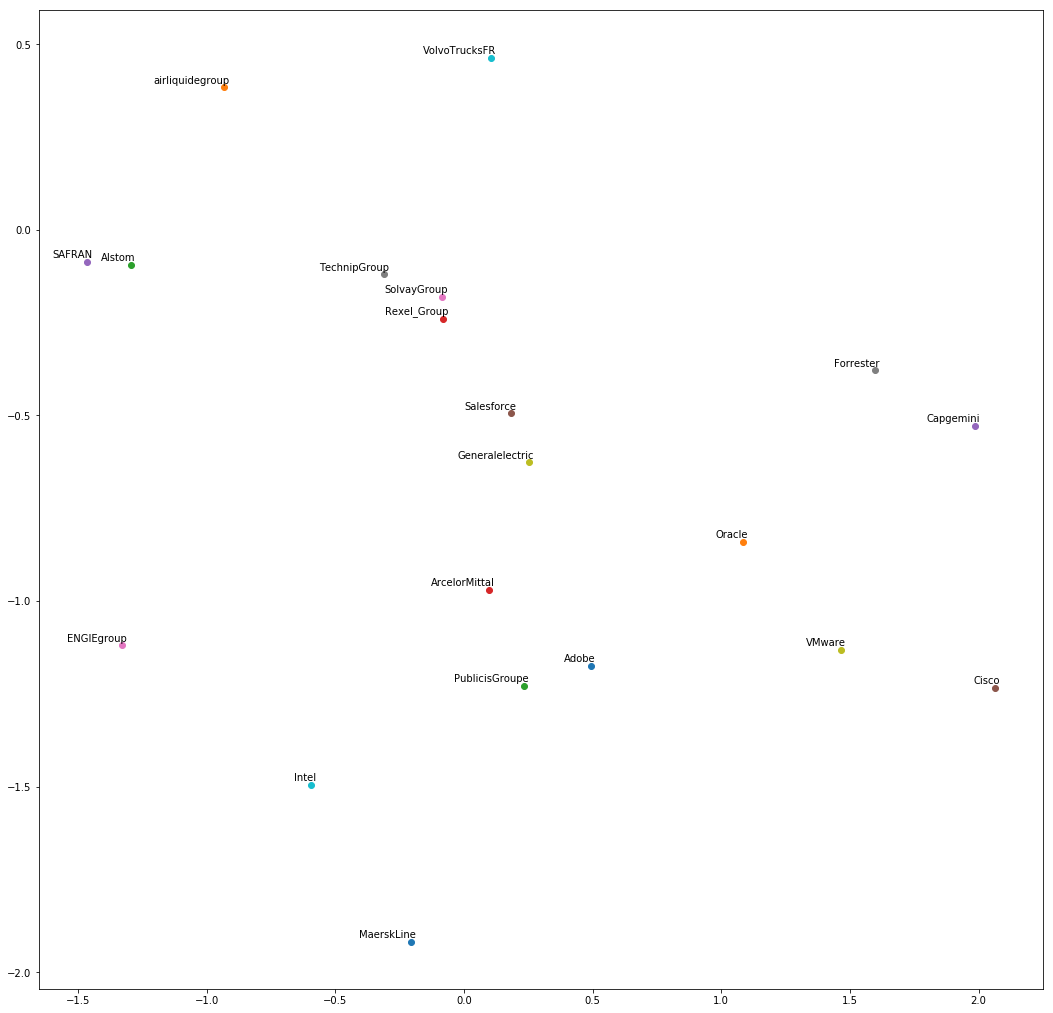

In [21]:
plot_with_labels(normalized_activations_topics[:, :2], clear_labels, 'firsts_topics_normalized_activation.png')

### Graphical representation of topics values by companies on three dimensions (to improve)

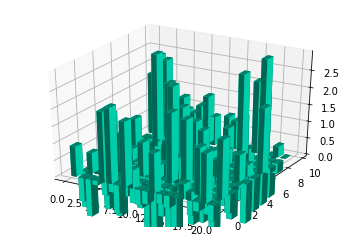

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []
for i, topics in enumerate(normalized_topics):
  for j, topic in enumerate(topics):
    x.append(i)
    y.append(j)
    z.append(topic)

ax1.bar3d(x, y, 0, 0.75, 0.75, z, color='#00ceaa')
plt.show()
plt.savefig(get_path('3DBarChart-topicsByCompanies.png', 'results'))

Print the n tweets for a company most in connection with the topic

Company names

In [66]:
', '.join(clear_labels)

'Adobe, airliquidegroup, Alstom, ArcelorMittal, Capgemini, Cisco, ENGIEgroup, Forrester, Generalelectric, Intel, MaerskLine, Oracle, PublicisGroupe, Rexel_Group, SAFRAN, Salesforce, SolvayGroup, TechnipGroup, VMware, VolvoTrucksFR'

In [67]:
def company_by_name(name):
  for company in companies:
    if company[0] == name:
      return company
  raise Exception('No company for this name')

def tweets_by_topics_and_company(company_name, topic, n=10):
  company = company_by_name(company_name)
  company_tweets = np.array(tweets[company[1][0]:company[1][1]])
  company_topics = lda_np[company[1][0]:company[1][1]]
  return company_tweets[company_topics[:,topic].argsort()][:n]
  
print(tweets_by_topics_and_company(company_name='Adobe', topic=1, n=20))

[ list(['re', 'closing', 'gender', 'pay', 'gap', 're', 'stopping', 'evp', 'next', 'ht'])
 list(['aside', 'hoping', 'people', 'forget', 'accidentally', 'pay', 'don', 'allow', 'auto', 'renew', 'turned'])
 list(['never', 'underestimate', 'power', 'flowchart', 'design', 'studio', 'uses', 'map', 'major', 'decisions'])
 list(['never', 'underestimate', 'power', 'flowchart', 'design', 'studio', 'uses', 'map', 'major', 'decisions'])
 list(['never', 'underestimate', 'power', 'flowchart', 'design', 'studio', 'uses', 'map', 'major', 'decisions'])
 list(['never', 'underestimate', 'power', 'flowchart', 'design', 'studio', 'uses', 'map', 'major', 'decisions'])
 list(['icfolson', 'mark', 'daugherty', 'presenting', 'immerse', 'virtual', 'aem', 'dev', 'conf', '15', '19'])
 list(['never', 'underestimate', 'power', 'flowchart', 'design', 'studio', 'uses', 'map', 'major', 'decisions'])
 list(['lmao', 'call', 'shared', 'experiential', 'hatred', 'don', 'started', 'eric', 'schmidt', 'ed'])
 list(['never', 'un